#### Code for the Poster Contribution A 133 "Go- no-go decisions based on gradually revealed visual information" at V-VSS 2021
##### by Clara Kuper
##### April 2021

In this code, I will review and discuss the data from a pilot experiment. Substantial parts of this analysis are 
presented at V-VSS 2021 in poster session A, on Saturday, the 22nd of May 2021. This notebook includes more analysis and 
information than included in the poster. Figures used in the poster are marked as 
"V-VSS 2021 Figure" and the corresponding analysis is marked as "V-VSS 2021 Analysis"

In this notebook, I will follow these steps:

0. Load the needed libraries and data files

1. review the data 
    
    a. describe size, structure
    
    b. show basic behavioural measurements (V-VSS 2021 Figures & Code)
    
    
2. describe different strategies to solve the task
    
    a. compare ideal observers using different strategies
    
    b. fit linear models to models the response type (go/ no-go). (V-VSS 2021 Figures & Code)
    
    c. fit linear models to the reaction time (V-VSS 2021 Figures & Code)
    
    
3. describe the time windows that had an influence on the response (V-VSS 2021 Figures & Code)
    
    a. modeled forwards, from the start of each trial
    
    b. modeled backwards, from the response in each trial
    
    
5. describe 3 mechanisms, based on drift diffusion models, and compare their simulated output to 3. (V-VSS 2021 Figures & Code)

In [1]:
# import the necessary libraries

## libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import utils.utils # custom functions
import math
import pickle

## filter warnings
import os
import re
import warnings
warnings.filterwarnings("ignore")

## import R
## we will use the R framework to fit mixed effect models
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['R_HOME'] = 'C:\Program Files\R\R-4.0.3'

## pymer is built on the lme4 package in R
import pymer4
from pymer4.models import Lmer, Lm

## import the pyDDM library
from ddm import Fittable, Model, Sample, Bound
from ddm.models import LossRobustBIC, DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision, Drift
from ddm.functions import fit_adjust_model, display_model
import ddm.plot

## data paths
path_data = './data/'
path_figs = './figures/'
path_models = './models/'

# data files
# wide df
df_short = pd.read_csv(path_data+'dataframe_short.csv', sep = ',')
# long df
df_long = pd.read_csv(path_data+'dataframe_long.csv', sep = ',')

## when fitting reaction times, we will need only the trial with "go" responses
responses = [0,1]
df_go, df_nogo = utils.utils.split_df(df_short, 'goResp', responses)

## print some information about the data frames:
print(f"The long df has {df_long.shape[1]} columns and {df_long.shape[0]} rows")
print(f"The short df has {df_short.shape[1]} columns and {df_short.shape[0]} rows")
print(f"The go df has {df_go.shape[0]} rows and the nogo df has {df_nogo.shape[0]} rows")


## define color maps for plotting
# subjects cm
s_cm = plt.cm.get_cmap('summer')(np.linspace(0,0.8, len(np.unique(df_long.subject))))
# go/no-go cm
g_cm = plt.cm.get_cmap('BrBG')
# correct/incorrect response (performance)
p_cm = plt.cm.get_cmap('RdYlGn')
# trial condition cmap(hit, pass)
c_cm = plt.cm.get_cmap('PuOr')
# time window cmap
t_cm =  plt.cm.get_cmap('Blues_r')
t_cm_discrete = t_cm(np.linspace(0, 0.8, len(np.unique(df_long.sampleID))))

# set fontsize for matplotlib
font = {'weight' : 'normal',
        'size'   : 25}
plt.rc('font', **font)
plt.rcParams['legend.title_fontsize'] = 25
plt.rcParams['legend.fontsize'] = 25

# standardize plot sizes:
in2cm = 1/2.54

height = 10 * in2cm
width = 10 * in2cm
gaps = 4 * in2cm


The long df has 17 columns and 57534 rows
The short df has 33 columns and 9589 rows
The go df has 4839 rows and the nogo df has 4750 rows


Introduction to the task:
The observer is asked to decide if a moving stimulus (attacker) will intercept or pass a target range (goal) on the screen.
The goal is revealed gradually while the attacker is moving, by showing dots (samples) that are sampled uniformly 
from the goal's position. 6 samples are shown over a trial duration of 1 second.
A response has to be given before the attacker reaches the goal, either by moving the hand from the keyboard to 
the screen and touching the estimated location of the goal (go), or by keeping the hand on the keyboard (no-go).

Below, I include an illustration of one trial, which can also be found in the "figures" folder.
![TrialLocal](./figures/example_trial.gif "Example Trial")

Introduction to the data structure:

The "short" data frame has one row for each trial. Properties of individual samples are stored in seperate columns

The "long" data frame has one row for each sample (six rows per trial), where properties for different samples are stored
in the same column.

The most important column names for this analysis are:

1. subject: the ID for each observer [o1, o2, o3, o4]
2. session: the session ID [1 - 3]
4. indTrial: a unique ID for each trial (only in the long data frame, corresponds to the index in the short data frame)
5. rea_time: reaction time in seconds (time from go signal till the movement to the screen started)
6. goResp: if observers produced a "go" or "no-go" response [1,0]
7. hitGoal: if the current trial was a hit or a pass trial [1,0]
8. answer: if the response was correct or incorrect [1,0]
9. response_cat: the response category [HIT, MISS, CORRECT_REJECTION, FALSE_ALARM]
10. sampleTimeMsGo: the time in ms at which a sample appeared relative to the go signal (with extensions _01 - _06 for the short data frame)
11. samplePosDegAtt: the distance from the attacker to the current sample in degree visual angle (with extensions for the short data frame)
12. sampleProbHit: the probability that the trial is a "Hit", computed from the current sample (with extensions for the short data frame)
13. sampleAccprobHit: the probability that the trial is a "Hit", computed from all samples up to (and including) the current sample (with extensions)
14. sampleID: the order in which samples were shown (only for the long data frame) [0 - 6]

Other columns are variations of the above, with different time units or expressed relatively to a different time in the 
experiment (e.g. sampleTimeSecResp is the time of sample appearance in seconds relative to the response onset).

In [2]:
## some summaries generated with pandas to get an overview of the data

# proportion of go/ no-go responses
summary_bSS = df_short.groupby(['subject', 'session']).describe().goResp
summary_bSS

count      mean       std  min  25%  50%  75%  max
subject session                                                    
o1      1        800.0  0.606250  0.488886  0.0  0.0  1.0  1.0  1.0
        2        800.0  0.522500  0.499806  0.0  0.0  1.0  1.0  1.0
        3        799.0  0.491865  0.500247  0.0  0.0  0.0  1.0  1.0
o2      1        796.0  0.430905  0.495514  0.0  0.0  0.0  1.0  1.0
        2        799.0  0.415519  0.493120  0.0  0.0  0.0  1.0  1.0
        3        797.0  0.432873  0.495785  0.0  0.0  0.0  1.0  1.0
o3      1        800.0  0.463750  0.498996  0.0  0.0  0.0  1.0  1.0
        2        798.0  0.431078  0.495538  0.0  0.0  0.0  1.0  1.0
        3        800.0  0.441250  0.496847  0.0  0.0  0.0  1.0  1.0
o4      1        800.0  0.640000  0.480300  0.0  0.0  1.0  1.0  1.0
        2        800.0  0.531250  0.499335  0.0  0.0  1.0  1.0  1.0
        3        800.0  0.536250  0.498996  0.0  0.0  1.0  1.0  1.0

every subject ran 3 session with ~800 successfully completed trials in each. The maximum number of excluded trials was 
4 in one session.

Subjects generated between 60 - 40 % go responses.

In [3]:
# proportion of correct/ incorrect responses by subject, session and condition
summary_a_bSSH = df_short.groupby(['subject','session', 'hitGoal']).describe().answer
summary_a_bSSH

count      mean       std  min  25%  50%  75%  max
subject session hitGoal                                                    
o1      1       0        400.0  0.672500  0.469889  0.0  0.0  1.0  1.0  1.0
                1        400.0  0.885000  0.319421  0.0  1.0  1.0  1.0  1.0
        2       0        400.0  0.820000  0.384669  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.865000  0.342152  0.0  1.0  1.0  1.0  1.0
        3       0        399.0  0.892231  0.310478  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.875000  0.331133  0.0  1.0  1.0  1.0  1.0
o2      1       0        400.0  0.935000  0.246835  0.0  1.0  1.0  1.0  1.0
                1        396.0  0.800505  0.400126  0.0  1.0  1.0  1.0  1.0
        2       0        400.0  0.957500  0.201980  0.0  1.0  1.0  1.0  1.0
                1        399.0  0.789474  0.408194  0.0  1.0  1.0  1.0  1.0
        3       0        400.0  0.937500  0.242365  0.0  1.0  1.0  1.0  1.0
                1        397.0  0.806045  0.395893  0.0  1.0  1.0  1.0  1.0
o3      1       0        400.0  0.827500  0.378288  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.755000  0.430626  0.0  1.0  1.0  1.0  1.0
        2       0        400.0  0.897500  0.303685  0.0  1.0  1.0  1.0  1.0
                1        398.0  0.761307  0.426822  0.0  1.0  1.0  1.0  1.0
        3       0        400.0  0.912500  0.282920  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.795000  0.404207  0.0  1.0  1.0  1.0  1.0
o4      1       0        400.0  0.615000  0.487205  0.0  0.0  1.0  1.0  1.0
                1        400.0  0.895000  0.306937  0.0  1.0  1.0  1.0  1.0
        2       0        400.0  0.825000  0.380443  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.887500  0.316376  0.0  1.0  1.0  1.0  1.0
        3       0        400.0  0.845000  0.362358  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.917500  0.275470  0.0  1.0  1.0  1.0  1.0

Responses are mostly correct.

In [4]:
# response times
summary_r_bSS = df_short.groupby(['subject','session','goResp']).describe().rea_time
summary_r_bSS

count      mean       std       min       25%  \
subject session goResp                                                  
o1      1       0         0.0       NaN       NaN       NaN       NaN   
                1       485.0  0.520437  0.086453  0.317108  0.450144   
        2       0         0.0       NaN       NaN       NaN       NaN   
                1       418.0  0.529800  0.087098  0.308625  0.466004   
        3       0         0.0       NaN       NaN       NaN       NaN   
                1       393.0  0.520102  0.080500  0.340964  0.457889   
o2      1       0         0.0       NaN       NaN       NaN       NaN   
                1       343.0  0.518824  0.074193  0.349766  0.466352   
        2       0         0.0       NaN       NaN       NaN       NaN   
                1       332.0  0.561288  0.068841  0.383147  0.514054   
        3       0         0.0       NaN       NaN       NaN       NaN   
                1       345.0  0.535802  0.068189  0.408158  0.483221   
o3      1       0         0.0       NaN       NaN       NaN       NaN   
                1       371.0  0.466831  0.104657  0.258133  0.387271   
        2       0         0.0       NaN       NaN       NaN       NaN   
                1       344.0  0.462944  0.093811  0.290775  0.391250   
        3       0         0.0       NaN       NaN       NaN       NaN   
                1       353.0  0.477539  0.090869  0.299756  0.407888   
o4      1       0         0.0       NaN       NaN       NaN       NaN   
                1       512.0  0.646261  0.059979  0.433151  0.608061   
        2       0         0.0       NaN       NaN       NaN       NaN   
                1       425.0  0.619411  0.052415  0.483152  0.582845   
        3       0         0.0       NaN       NaN       NaN       NaN   
                1       429.0  0.616941  0.052586  0.466287  0.582670   

                             50%       75%       max  
subject session goResp                                
o1      1       0            NaN       NaN       NaN  
                1       0.516454  0.583534  0.757948  
        2       0            NaN       NaN       NaN  
                1       0.516490  0.591050  0.758108  
        3       0            NaN       NaN       NaN  
                1       0.516084  0.582689  0.724802  
o2      1       0            NaN       NaN       NaN  
                1       0.499829  0.565983  0.724800  
        2       0            NaN       NaN       NaN  
                1       0.557913  0.607766  0.758028  
        3       0            NaN       NaN       NaN  
                1       0.516466  0.566340  0.774631  
o3      1       0            NaN       NaN       NaN  
                1       0.457863  0.532976  0.766424  
        2       0            NaN       NaN       NaN  
                1       0.450177  0.518973  0.766537  
        3       0            NaN       NaN       NaN  
                1       0.474843  0.533026  0.758314  
o4      1       0            NaN       NaN       NaN  
                1       0.649628  0.691437  0.774645  
        2       0            NaN       NaN       NaN  
                1       0.624387  0.658097  0.774663  
        3       0            NaN       NaN       NaN  
                1       0.616244  0.649588  0.774639

We only have reaction times for "go" responses, but not for "no-go" responses.
Observer seem to differ in their response times.

ValueError: The Subplot must have been created in the present figure

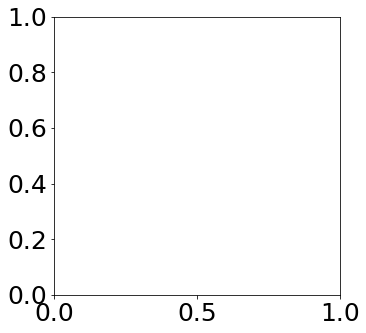

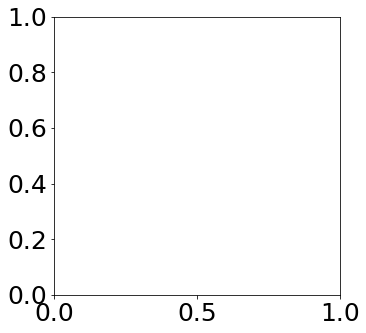

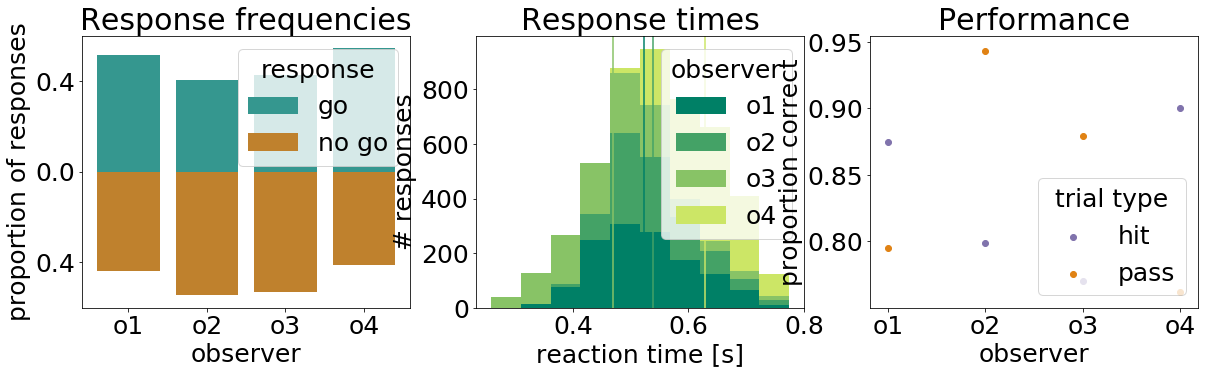

In [7]:
# Build a figure for response characteristics
# individual figures for poster
## V-VSS 2021 figures
VSS2021_rts, axs_rts = plt.subplots(1,1, figsize = (width*1.3, height*1.3))
VSS2021_performance, axs_perf = plt.subplots(1,1, figsize = (width*1.3, height*1.3))


fig, axs = utils.utils.make_summary_plot(df_short, g_cm, s_cm, c_cm)


# # one individual figure for the poster
# axs_rts.hist(rts, stacked = True, color = s_cm, label = observers)
# 
#     
# # individual plot for poster
# axs_perf.scatter(observers,summary_a_bSH.loc[((slice("AD","AG")),[1]), :]['mean'].values, label = 'hit', color = c_cm(np.linspace(0.2,0.8,2))[1])
# axs_perf.scatter(observers,summary_a_bSH.loc[((slice("AD","AG")),[0]), :]['mean'].values, label = 'pass', color = c_cm(np.linspace(0.2,0.8,2))[0])
# axs_perf.set_xlabel('observer')
# axs_perf.set_ylabel('proportion correct')
# axs_perf.legend(title = 'trial type', loc = 'lower left')
# axs_perf.set_ylim([0.5, 1])
  
VSS2021_rts.add_subplot(axs[0])